In [7]:
from skimage import io, util
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
from myImageLib import dirrec, to8bit, bpass
from IPython.display import clear_output, display
import trackpy as tp
from scipy import signal, ndimage, misc

In [2]:
def threshold(img, percentile=1, invert=True):
    threshold = np.percentile(img, percentile)
    imgt = img.copy()
    if invert == True:
        imgt[img<=threshold] = 255
        imgt[img>threshold] = 0
    else:
        imgt[img<=threshold] = 0
        imgt[img>threshold] = 255
    return imgt
def locate_particle(img, invert=True, **kwargs):
    area = (250, 10000)
    ar = (0.2, 1)
    thres_percentile = 1
    for kw in kwargs:
        if kw == 'area':
            area = kwargs[kw]
        elif kw == 'ar':
            ar = kwargs[kw]
        elif kw == 'thres_percentile':
            thres_percentile = kwargs[kw]
    imgt = threshold(img, percentile=thres_percentile, invert=invert)
    data = []
    
    label_image = skimage.measure.label(imgt)
    for region in skimage.measure.regionprops(label_image, intensity_image=img, coordinates='rc'):
        if region.major_axis_length == 0:
            continue
        else:
            region_ar = region.minor_axis_length / region.major_axis_length 
        if region.mean_intensity < 1:
            continue
        if region.area < min(area) or region.area > max(area):
            continue
        if region_ar < min(ar) or region_ar > max(ar):
            continue
        y, x = region.centroid
        major = region.major_axis_length
        minor = region.minor_axis_length
        angle = region.orientation / math.pi * 180
        if angle < 0:
            angle = -angle + 90
        else:
            angle = 90 - angle
        data.append([x, y, angle, major, minor, region.area])               
    column_names = ['X', 'Y', 'Angle', 'Major', 'Minor', 'Area']
    particles = pd.DataFrame(data=data, columns=column_names)
    return particles
def stack_track(imgStack, **kwargs):
    area = (250, 10000)
    ar = (0, 0.7)
    thres_percentile = 1
    for kw in kwargs:
        if kw == 'area':
            area = kwargs[kw]
        elif kw == 'ar':
            ar = kwargs[kw]
        elif kw == 'thres_percentile':
            thres_percentile = kwargs[kw]
    stack_particles = pd.DataFrame()
    for num, img in enumerate(imgStack):        
        particles = locate_particle(img, area=area, ar=ar, thres_percentile=thres_percentile).assign(Slice=num)
        stack_particles = stack_particles.append(particles)
        print(str(len(particles)) + ' particles are found in frame ' + str(num))    
    return stack_particles

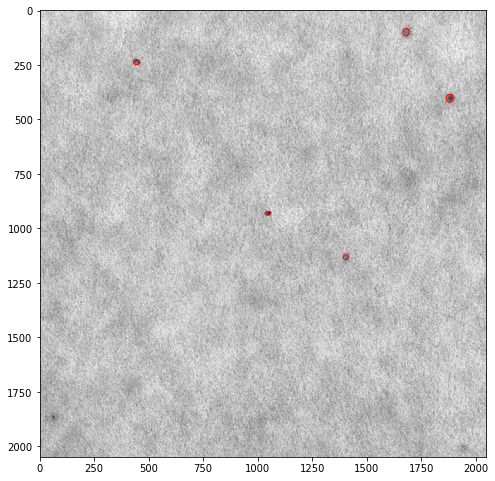

In [262]:
# Test parameters
folder = r'R:\Dip\DNA_chain\fluorescent\4k bp, 10ug per ml_3'
img = io.imread(os.path.join(folder, '0900.tif'))
imgt = threshold(img, percentile=1)
fig, ax = plt.subplots(figsize=(8,9))
ax.imshow(img, cmap='gray')
particle = locate_particle(img, invert=True, thres_percentile=.1, area=(200, 1200), ar=(0.5, 1))
for num, p in particle.iterrows():
    x = p.X
    y = p.Y
    width = p.Major
    height = p.Minor
    angle = p.Angle
    elli = ax.add_patch(mpatches.Ellipse((x,y), width, height, angle, fc='none', ec='red'))

In [205]:
particles.shape

(2442, 7)

## Chain tracking

In [263]:
# Find particles
imgDirs = dirrec(folder, '*.tif')
nameList = []
dirList = []
for imgDir in imgDirs:
    path, file = os.path.split(imgDir)
    name, ext = os.path.splitext(file)
    nameList.append(name)
    dirList.append(imgDir)
fileList = pd.DataFrame()
fileList = fileList.assign(Name=nameList, Dir=dirList)
fileList = fileList.sort_values(by=['Name'])
particles = pd.DataFrame()
for num, imgDir in enumerate(fileList.Dir):  
    clear_output(wait=True)
    print('Frame %d' % num)
    img = io.imread(imgDir)
    particle = locate_particle(img, invert=True, thres_percentile=.1, area=(200, 1500), ar=(0.5, 1))
    particle = particle.assign(frame=num)
    particles = particles.append(particle)

Frame 1199


In [264]:
particles.to_csv(os.path.join(folder, 'finding.csv'), index=False)

Drawing multicolor lines takes awhile. Come back in a minute.


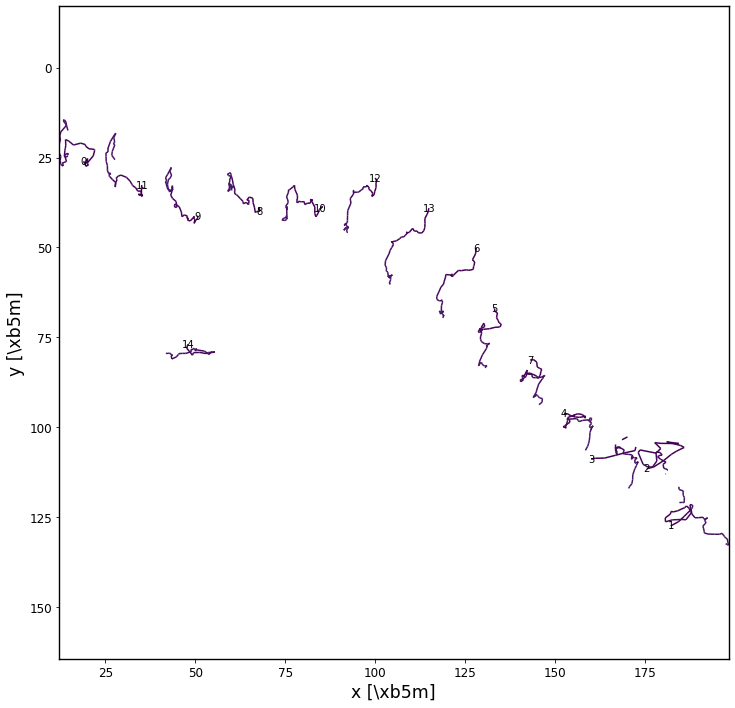

In [19]:
%matplotlib inline
folder = r'I:\Github\Python\Tracking\tracking\test_images'
particles = pd.read_csv(os.path.join(folder, 'finding.csv'))
particles.rename(mapper={'Slice': 'frame', 'X': 'x', 'Y': 'y'}, axis=1, inplace=True)
particles = tp.link_df(particles, 25, memory=50)
particles = tp.filter_stubs(particles, threshold=0)
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('equal')
tp.plot_traj(particles, mpp=0.108, colorby='frame', cmap='viridis', label=True, ax=ax)

In [30]:
particles.rename_axis('index')

,,Area,x,y,Major,Minor,Angle,frame,particle
index,,,,,,,,,
1,1,1082,39.985,70.392,39.083,35.249,128.149,1,0
1,16,389,396.477,290.778,23.863,20.756,52.451,1,1
1,15,654,368.688,274.680,29.871,27.877,51.114,1,2
1,14,726,354.696,243.322,31.100,29.723,52.915,1,3
1,13,506,324.304,237.862,27.310,23.590,50.690,1,4
1,11,463,95.656,180.383,25.592,23.035,24.739,1,5
1,10,822,290.119,182.696,34.277,30.534,58.910,1,6
1,9,839,270.325,153.672,35.113,30.423,44.623,1,7
1,12,777,308.922,211.875,32.816,30.147,60.449,1,8


In [ ]:
a = particles.loc[particles.particle==0]

In [266]:
particles = particles.loc[(particles.particle==19)|(particles.particle==49)|(particles.particle==4)|
                         (particles.particle==30)|(particles.particle==20)|(particles.particle==32)|
                         (particles.particle==1)|(particles.particle==41)] 

In [22]:
particles = particles.where(particles.particle!=14).dropna()

In [10]:
particles.particle.drop_duplicates().shape

(22,)

Drawing multicolor lines takes awhile. Come back in a minute.


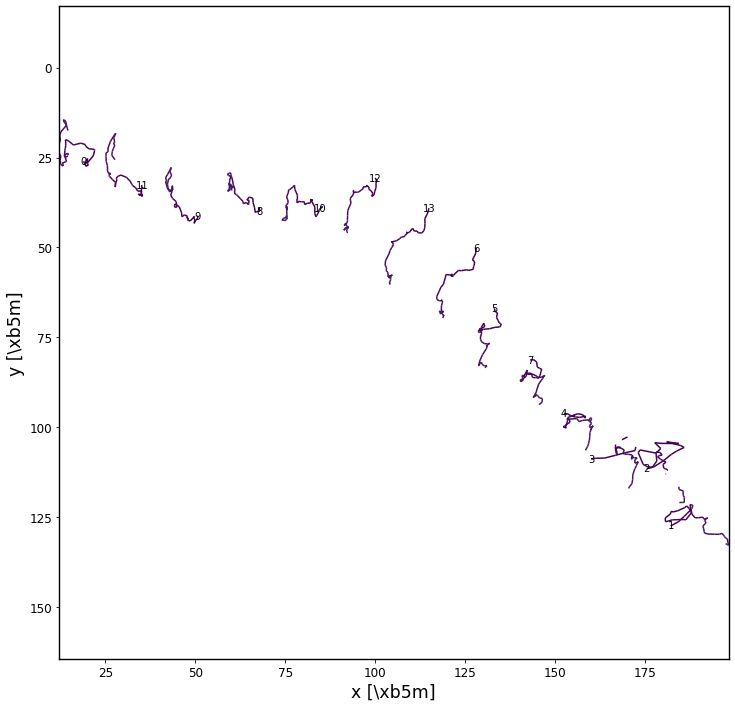

In [23]:
fig, ax = plt.subplots(figsize=(12,12))
ax.axis('equal')
tp.plot_traj(particles, mpp=0.33, colorby='frame', cmap='viridis', label=True, ax=ax)

In [24]:
particles.to_csv(os.path.join(folder, 'tracking.csv'), index=False)

In [14]:
ar = particles.Minor / particles.Major

In [31]:
particles = particles.assign(AR=ar)

In [32]:
particles = particles.loc[particles.AR > 0.8]

In [25]:
particles.drop(columns='frame', inplace=True)

In [34]:
particles = particles.rename_axis('index')

In [36]:
particles = tp.link_df(particles, 25, memory=50)
particles = tp.filter_stubs(particles, threshold=50)

Frame 500: 12 trajectories present.


In [37]:
particles.particle.drop_duplicates().shape

(18,)

# Verification

In [3]:
folder = r'R:\Dip\DNA_chain\fluorescent\4k bp, 10ug per ml_2\test'
interval = 1
count = 0

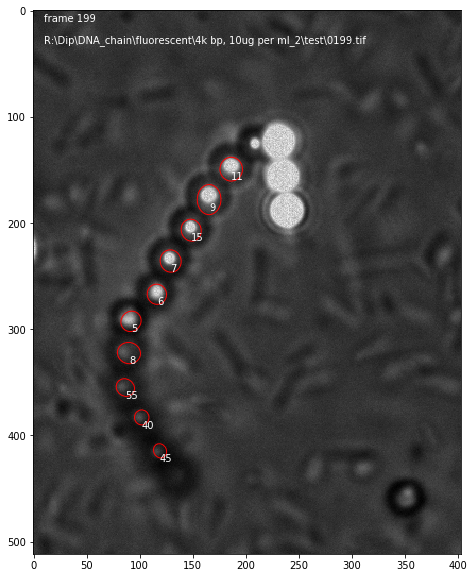

In [4]:
imgDirs = dirrec(folder, '*.tif')
nameList = []
dirList = []
for imgDir in imgDirs:
    path, file = os.path.split(imgDir)
    name, ext = os.path.splitext(file)
    nameList.append(int(name))
    dirList.append(imgDir)
fileList = pd.DataFrame()
fileList = fileList.assign(Name=nameList, Dir=dirList)
fileList = fileList.sort_values(by=['Name'])
traj = pd.read_csv(os.path.join(folder, 'tracking.csv'), sep=',')
for frame in range(0, len(fileList)):
    if count < interval:
        count += 1
        continue
    else:
        count = 0
    img = io.imread(fileList.Dir.iloc[frame])
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    plt.text(10, 10, 'frame {0}'.format(frame), color='white')
    plt.text(10, 30, fileList.Dir.iloc[frame], color='white')
    sub_traj = traj.loc[traj.frame==frame]
    ax = plt.gca()
    for num, p in sub_traj.iterrows():
        x = p.x
        y = p.y
        width = p.Major
        height = p.Minor
        angle = p.Angle
        # width = 20
        # height = 20
        # angle = 0
        elli = ax.add_patch(mpatches.Ellipse((x,y), width, height, angle, fc='none', ec='red'))
        plt.text(x, y+10, '{0:d}'.format(int(p.particle)), color='white')
    plt.pause(0.001)
    clear_output(wait=True)

## Jan 9th, 2020

In [4]:
%matplotlib nbagg
img = io.imread(r'I:\Github\Python\Tracking\tracking\test_images\0000.tif')

<IPython.core.display.Javascript object>


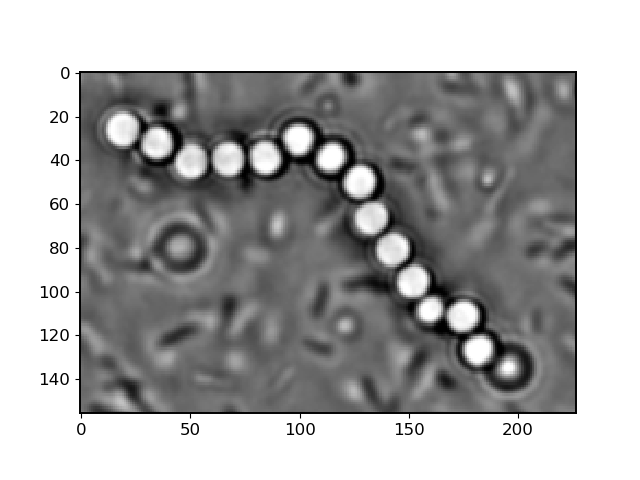

In [8]:
plt.imshow(img, cmap='gray')

<IPython.core.display.Javascript object>


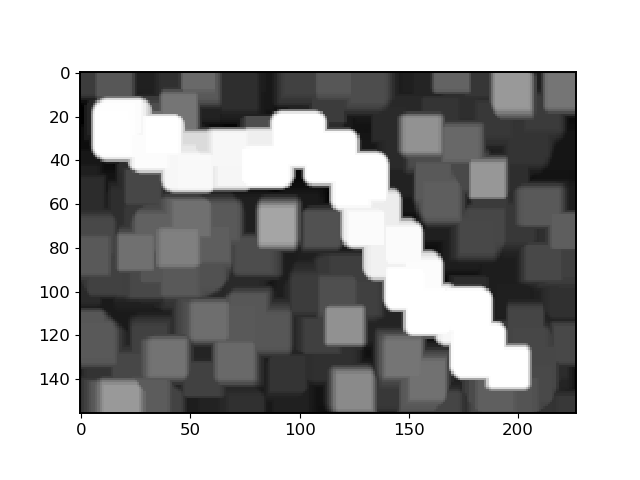

In [10]:
mf = ndimage.maximum_filter(img, size=15)
plt.imshow(mf, cmap='gray')